# Herron Topic 4 - Practice for Section 05

## Announcements

1. This week:
    1. Tuesday: Herron Topic 4 on portfolio optimization
    2. Thursday and Friday: MSFQ assessment exam in your scheduled classroom and time
2. Next week: Group work on Project 3 all week
3. Last week:
    1. Tuesday: Project 3 due at 11:59 PM on Tuesday, 4/23
    2. ThursdayFriday: Office hours during class time

## 10-Minute Recap

Pease review the lecture notebook, which provides a streamlined introduction to optimization in Python!

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.optimize as sco
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years

Note that `sco.minimize()` finds *minimums*, so you need to minimize the *negative* Sharpe Ratio.

In [3]:
matana = (
    yf.download(tickers='META AAPL TSLA AMZN NVDA GOOG')
    ['Adj Close']
    .iloc[:-1]
    .pct_change()
)

[*********************100%%**********************]  6 of 6 completed


In [4]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .div(100)
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_17984\2049483829.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


In [5]:
def calc_sharpe(x, r, tgt, ppy):
    rp = r.dot(x)
    rp_tgt = rp.sub(tgt)
    return np.sqrt(ppy) * rp_tgt.mean() / rp_tgt.std()

In [6]:
def calc_neg_sharpe(x, r, tgt, ppy):
    return -1 * calc_sharpe(x=x, r=r, tgt=tgt, ppy=ppy)

After class, I decided to write a `get_equal_weights()` function to easily calculate $\frac{1}{n}$ portfolio weights.

In [7]:
def get_equal_weights(r):
    n = r.shape[1]
    return np.ones(n) / n

In [8]:
x0 = get_equal_weights(r=matana)
x0

array([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

---

We can test our function!

In [9]:

calc_sharpe(
    x=x0,
    r=matana.loc['2021':'2023'],
    tgt=ff['RF'],
    ppy=252
)

0.6336

In [10]:
rp_tgt = matana.loc['2021':'2023'].dot(x0).sub(ff['RF'])
np.sqrt(252) * rp_tgt.mean() / rp_tgt.std()

0.6336

In [11]:
calc_neg_sharpe(
    x=x0, 
    r=matana.loc['2021':'2023'], 
    tgt=ff['RF'], 
    ppy=252
)

-0.6336

---

In [12]:
res_sr = sco.minimize(
    fun=calc_neg_sharpe,
    x0=matana.pipe(get_equal_weights),
    args=(matana.loc['2021':'2023'], ff['RF'], 252),
    bounds=((0, 1) for c in matana.columns),
    constraints=(
        {'type':'eq', 'fun': lambda x: x.sum() - 1} # eq constraint met when equal to zero
    )
)

res_sr

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0660863115414434
       x: [ 8.921e-17  9.213e-18  0.000e+00  0.000e+00  1.000e+00
            0.000e+00]
     nit: 5
     jac: [ 3.206e-02  3.530e-01 -1.079e-02  1.151e-01 -3.910e-02
            2.773e-01]
    nfev: 35
    njev: 5

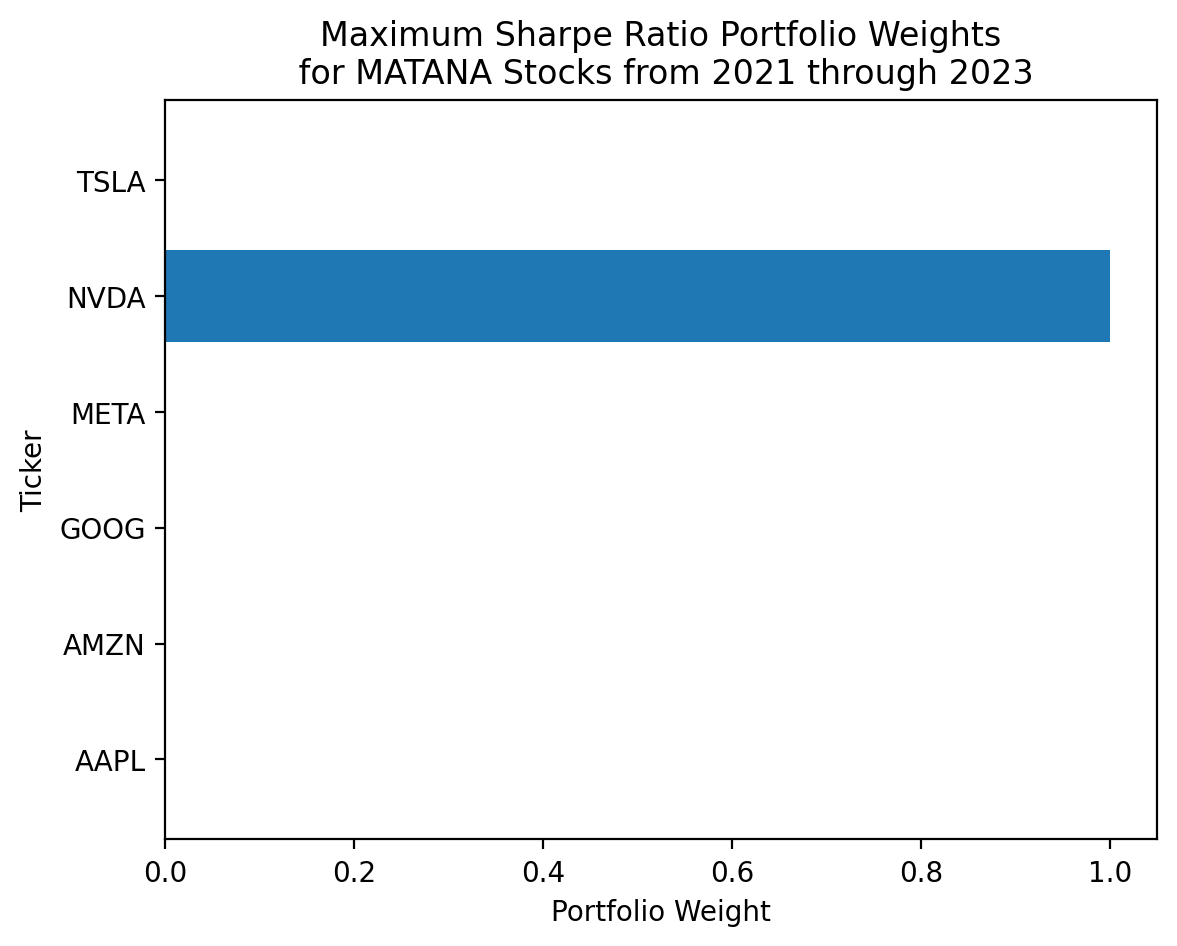

In [13]:
plt.barh(
    y=matana.columns,
    width=res_sr['x']
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Maximum Sharpe Ratio Portfolio Weights\n for MATANA Stocks from 2021 through 2023')
plt.show()

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but allow short weights up to 10% on each stock

In [14]:
res_sr_2 = sco.minimize(
    fun=calc_neg_sharpe,
    x0=matana.pipe(get_equal_weights),
    args=(matana.loc['2021':'2023'], ff['RF'], 252),
    bounds=((-0.1, 1.5) for c in matana.columns),
    constraints=(
        {'type':'eq', 'fun': lambda x: x.sum() - 1} # eq constraint met when equal to zero
    )
)

res_sr_2

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1353011989460526
       x: [-1.000e-01 -1.000e-01  2.348e-01 -1.000e-01  1.165e+00
           -1.000e-01]
     nit: 6
     jac: [ 2.074e-02  3.100e-01  1.634e-02  7.954e-02  1.697e-02
            1.877e-01]
    nfev: 42
    njev: 6

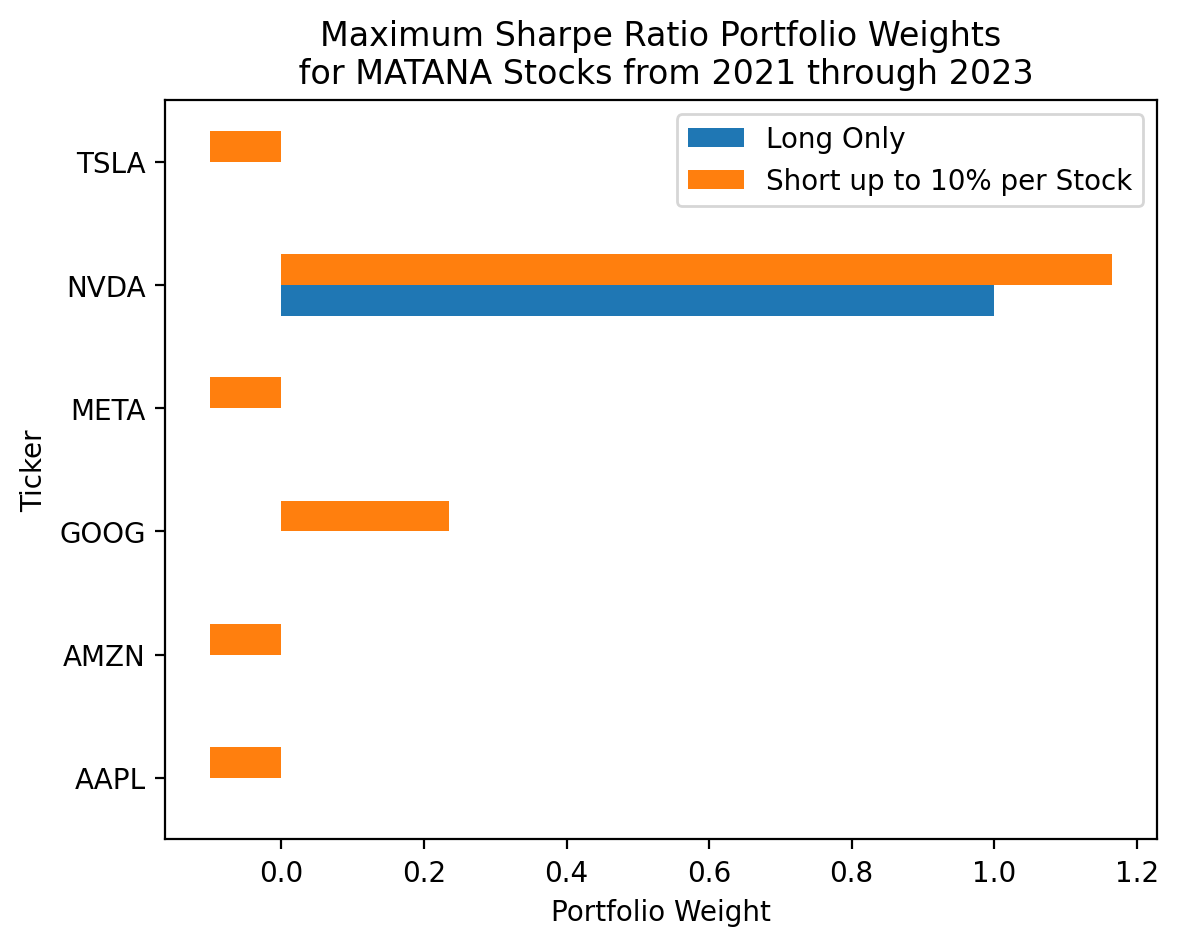

In [15]:
(
    pd.DataFrame(
        data={
            'Long Only': res_sr['x'],
            'Short up to 10% per Stock': res_sr_2['x']
        },
        index=matana.columns
    )
    .plot(kind='barh')
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Maximum Sharpe Ratio Portfolio Weights\n for MATANA Stocks from 2021 through 2023')
plt.show()

By relaxing the long-only constrain (via changes to `bounds=`), the weights on AAPL, AMZN, META, and TSLA go from zero to -10%.
Also, the Sharpe Ratio increases because we relax a binding constraint.

In [16]:
calc_sharpe(
    x=res_sr['x'],
    r=matana.loc['2021':'2023'],
    tgt=ff['RF'],
    ppy=252
)

1.0661

In [17]:
calc_sharpe(
    x=res_sr_2['x'],
    r=matana.loc['2021':'2023'],
    tgt=ff['RF'],
    ppy=252
)

1.1353

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but allow total short weights of up to 30%

***Now we need an inequality constraint!***
We will use an inequality constraint to make sure the sum of the negative portfolio weights is greater than $-0.3$.

In [18]:
x = np.arange(6) - 3
x

array([-3, -2, -1,  0,  1,  2])

We do this by:

1. Slicing the negative weights in `x` with `x[x < 0]`
2. Constraining the sum of these negative weights to be $\geq -0.3$, which is met when `x[x < 0].sum() + 0.3` is non-negative.

In [19]:
res_sr_3 = sco.minimize(
    fun=calc_neg_sharpe,
    x0=matana.pipe(get_equal_weights),
    args=(matana.loc['2021':'2023'], ff['RF'], 252),
    bounds=((-0.3, 1.3) for c in matana.columns),
    constraints=(
        {'type':'eq', 'fun': lambda x: x.sum() - 1}, # eq constraint met when = 0
        {'type':'ineq', 'fun': lambda x: x[x < 0].sum() + 0.3} # ineq constraint met when >= 0
    )
)

res_sr_3

C:\Users\r.herron\AppData\Local\miniconda3\envs\fina6333\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1616508281422926
       x: [ 8.532e-09 -2.997e-01  2.717e-01 -3.268e-07  1.028e+00
           -3.074e-04]
     nit: 44
     jac: [ 5.523e-02  3.114e-01  4.330e-02  1.434e-01  4.189e-02
            3.026e-01]
    nfev: 491
    njev: 44

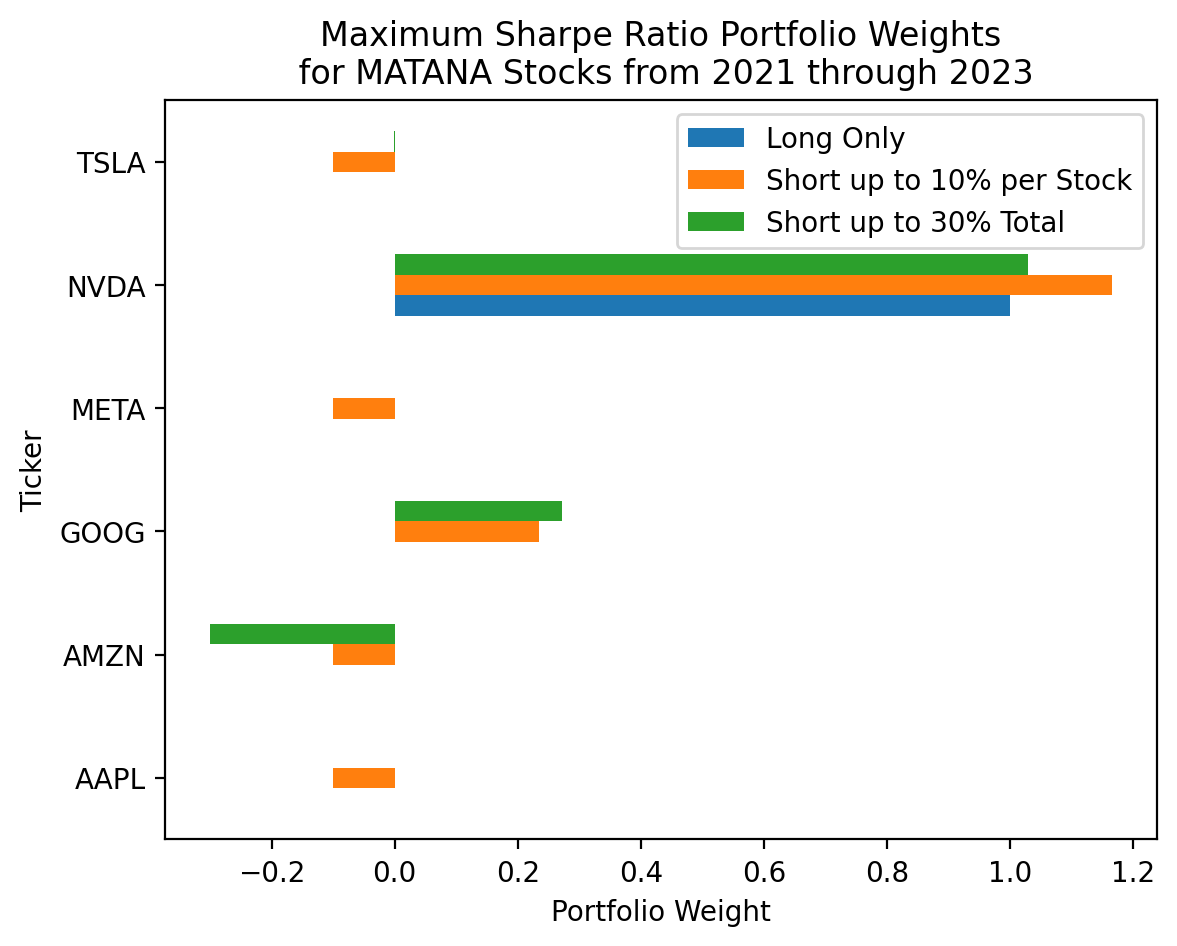

In [20]:
(
    pd.DataFrame(
        data={
            'Long Only': res_sr['x'],
            'Short up to 10% per Stock': res_sr_2['x'],
            'Short up to 30% Total': res_sr_3['x']
        },
        index=matana.columns
    )
    .plot(kind='barh')
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Maximum Sharpe Ratio Portfolio Weights\n for MATANA Stocks from 2021 through 2023')
plt.show()

The Sharpe Ratio is higher here than in the previous exercise, but this will not always be the case because we  relax slightly different constraints.
That is, here we allow up to 30% short in one stock, but only allow up to 30% short across all stocks.
In the previous example, we only allow up to 10% short in each stock, but allow up to 50% short across all stocks.

In [21]:
calc_sharpe(
    x=res_sr_2['x'],
    r=matana.loc['2021':'2023'],
    tgt=ff['RF'],
    ppy=252
)

1.1353

In [22]:
calc_sharpe(
    x=res_sr_3['x'],
    r=matana.loc['2021':'2023'],
    tgt=ff['RF'],
    ppy=252
)

1.1617

### Find the maximum Sharpe Ratio portfolio of MATANA stocks over the last three years, but do not allow any weight to exceed 30% in magnitude

In [23]:
res_sr_4 = sco.minimize(
    fun=calc_neg_sharpe,
    x0=matana.pipe(get_equal_weights),
    args=(matana.loc['2021':'2023'], ff['RF'], 252),
    bounds=((0, 0.3) for c in matana.columns),
    constraints=(
        {'type':'eq', 'fun': lambda x: x.sum() - 1}, # eq constraint met when = 0
    )
)

res_sr_4

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8830356530532761
       x: [ 3.000e-01  0.000e+00  3.000e-01  1.000e-01  3.000e-01
            6.072e-18]
     nit: 3
     jac: [ 1.089e-01  5.852e-01  8.385e-02  3.099e-01 -5.076e-01
            3.305e-01]
    nfev: 21
    njev: 3

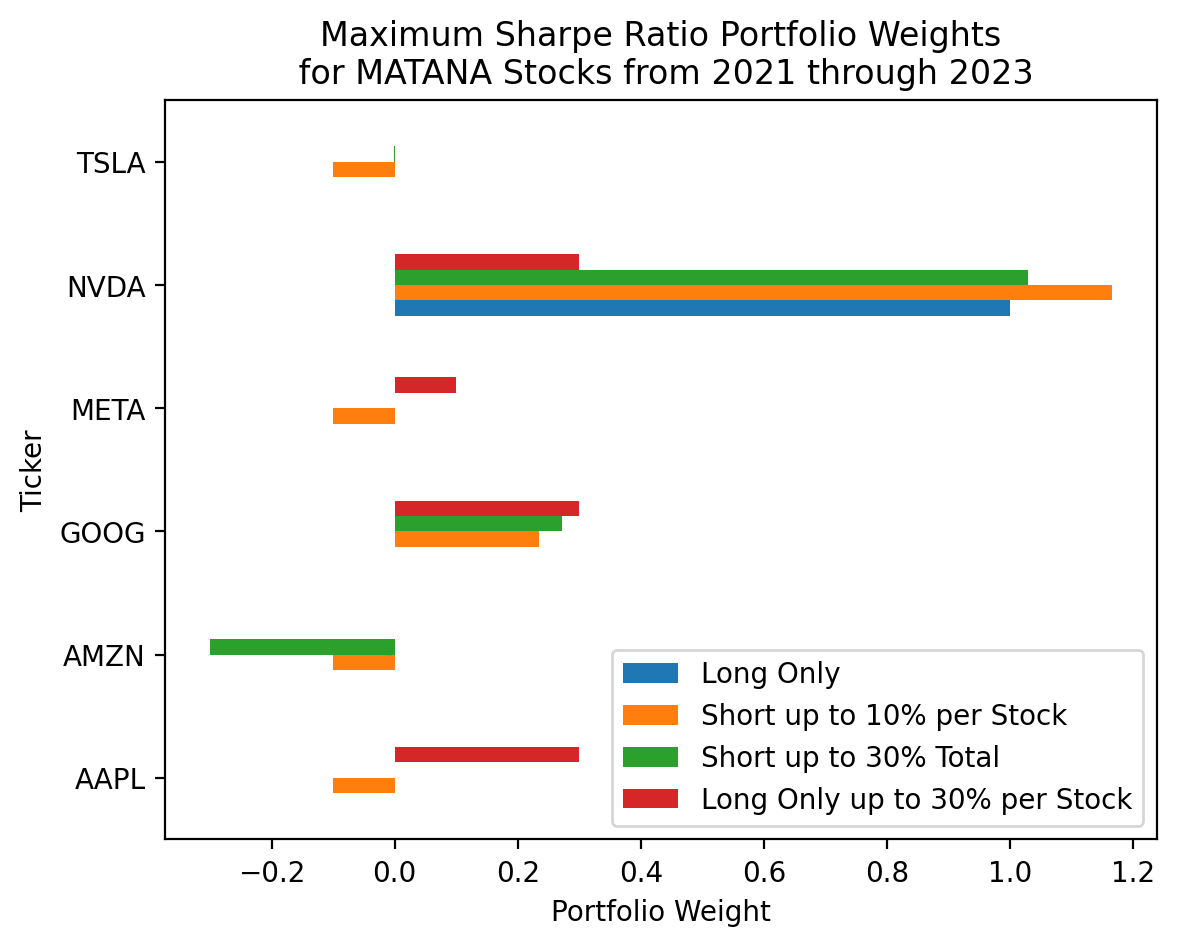

In [24]:
(
    pd.DataFrame(
        data={
            'Long Only': res_sr['x'],
            'Short up to 10% per Stock': res_sr_2['x'],
            'Short up to 30% Total': res_sr_3['x'],
            'Long Only up to 30% per Stock': res_sr_4['x']
        },
        index=matana.columns
    )
    .plot(kind='barh')
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Maximum Sharpe Ratio Portfolio Weights\n for MATANA Stocks from 2021 through 2023')
plt.show()

### Find the minimum 95% Value at Risk (Var) portfolio of MATANA stocks over the last three years

More on VaR [here](https://en.wikipedia.org/wiki/Value_at_risk).

In [25]:
def calc_var(x, r, q):
    return r.dot(x).quantile(q)

In [26]:
def calc_neg_var(x, r, q):
    return -1 * calc_var(x=x, r=r, q=q)

In [27]:
res_var = sco.minimize(
    fun=calc_neg_var,
    x0=matana.pipe(get_equal_weights),
    args=(matana.loc['2021':'2023'], 0.05),
    bounds=[(0,1) for c in matana],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_var

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.032516587529765696
       x: [ 2.102e-01  1.989e-01  2.292e-01  1.593e-01  3.434e-21
            2.024e-01]
     nit: 7
     jac: [ 3.662e-02  2.644e-02  2.760e-02  2.072e-02  3.928e-02
            4.908e-02]
    nfev: 61
    njev: 7

In [28]:
calc_var(x=res_var['x'], r=matana.loc['2021':'2023'], q=0.05)

-0.0325

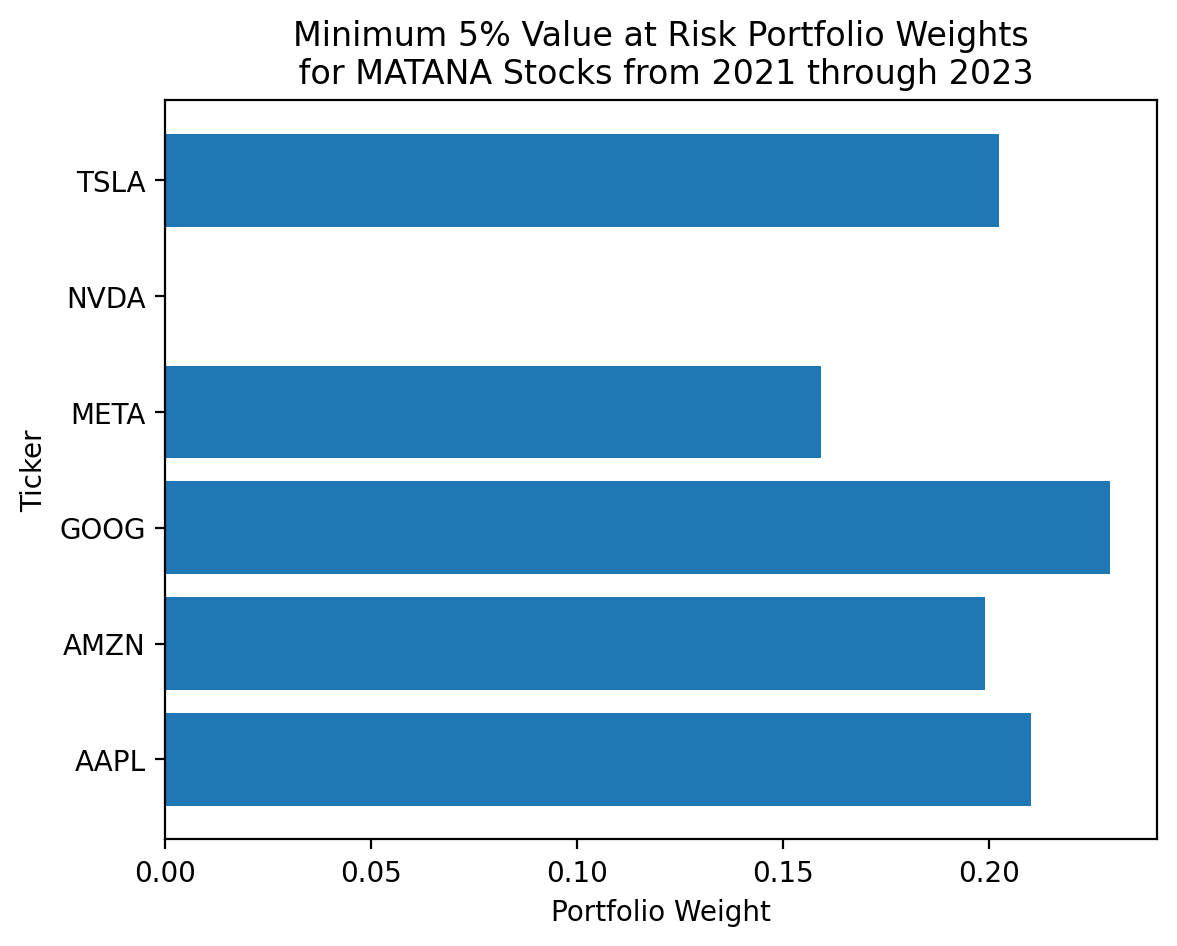

In [29]:
plt.barh(
    y=matana.columns,
    width=res_var['x']
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Minimum 5% Value at Risk Portfolio Weights\n for MATANA Stocks from 2021 through 2023')
plt.show()

### Find the minimum maximum draw down portfolio of MATANA stocks over the last three years

In [30]:
def calc_max_dd(x, r):
    rp = r.dot(x)
    pp = rp.add(1).cumprod()
    cummax = pp.cummax()
    dd = (cummax - pp) / cummax
    return dd.max()

In [31]:
res_dd = sco.minimize(
    fun=calc_max_dd,
    x0=matana.pipe(get_equal_weights),
    args=(matana.loc['2021':'2023'],),
    bounds=[(0,1) for c in matana.columns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_dd

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.30912803551781853
       x: [ 1.000e+00  5.551e-16  2.026e-15  6.870e-16  9.645e-16
            9.021e-16]
     nit: 6
     jac: [ 2.995e-01  4.945e-01  3.778e-01  6.189e-01  4.966e-01
            8.402e-01]
    nfev: 42
    njev: 6

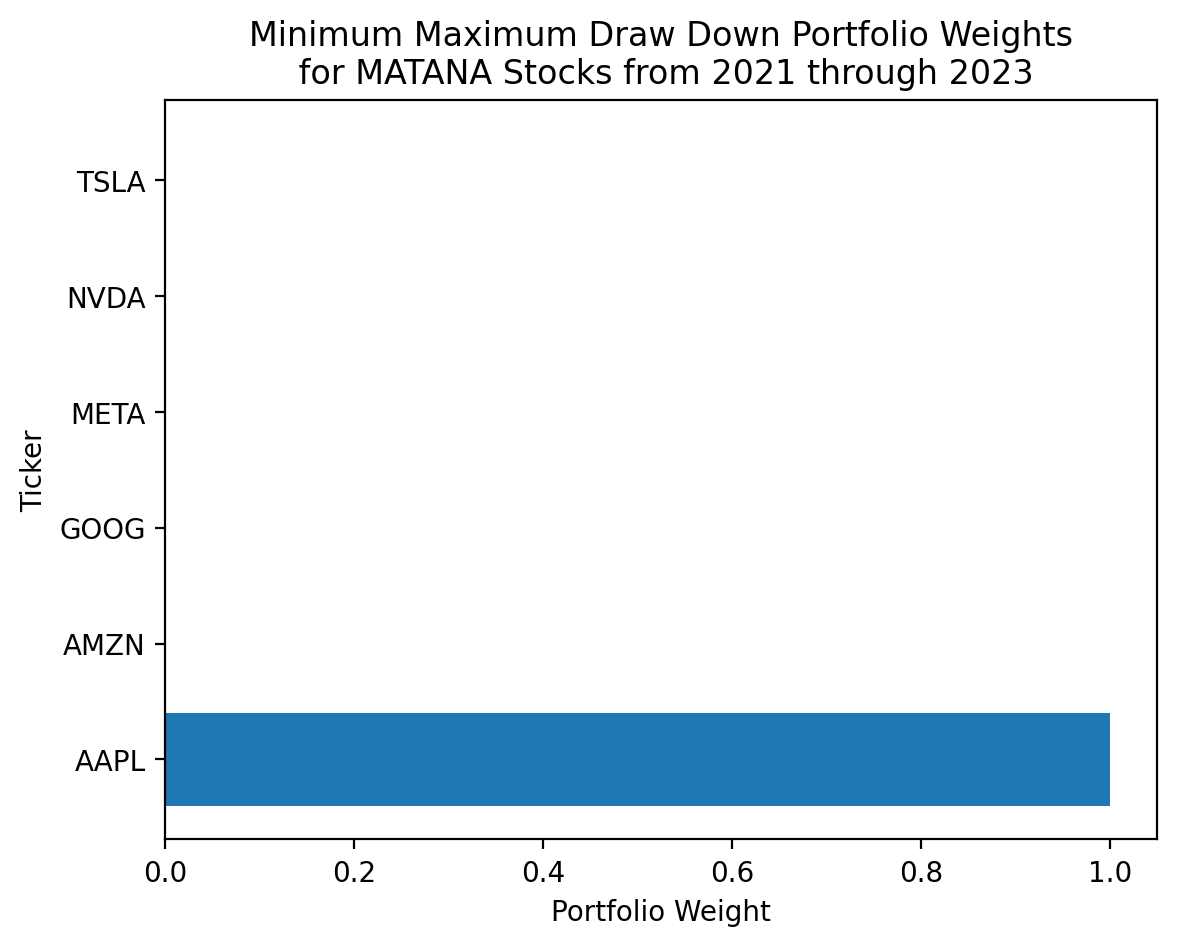

In [32]:
plt.barh(
    y=matana.columns,
    width=res_dd['x']
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Minimum Maximum Draw Down Portfolio Weights\n for MATANA Stocks from 2021 through 2023')
plt.show()

### Find the minimum maximum draw down portfolio with all available data for the current Dow-Jones Industrial Average (DJIA) stocks

You can find the [DJIA tickers on Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).

In [33]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]['Symbol'].to_list()

In [34]:
djia = (
    yf.download(tickers=tickers)
    ['Adj Close']
    .iloc[:-1]
    .pct_change()
)

[*********************100%%**********************]  30 of 30 completed


In [35]:
res_dd_2 = sco.minimize(
    fun=calc_max_dd,
    x0=djia.pipe(get_equal_weights),
    args=(djia.loc['2021':'2023'],),
    bounds=[(0,1) for c in djia.columns],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # minimize drives "eq" constraints to zero
    )
)

res_dd_2

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.07677715628739014
       x: [ 3.926e-02  2.069e-02 ...  1.693e-02  4.226e-02]
     nit: 29
     jac: [-2.236e-02  1.808e-01 ...  4.257e-02  9.219e-02]
    nfev: 947
    njev: 29

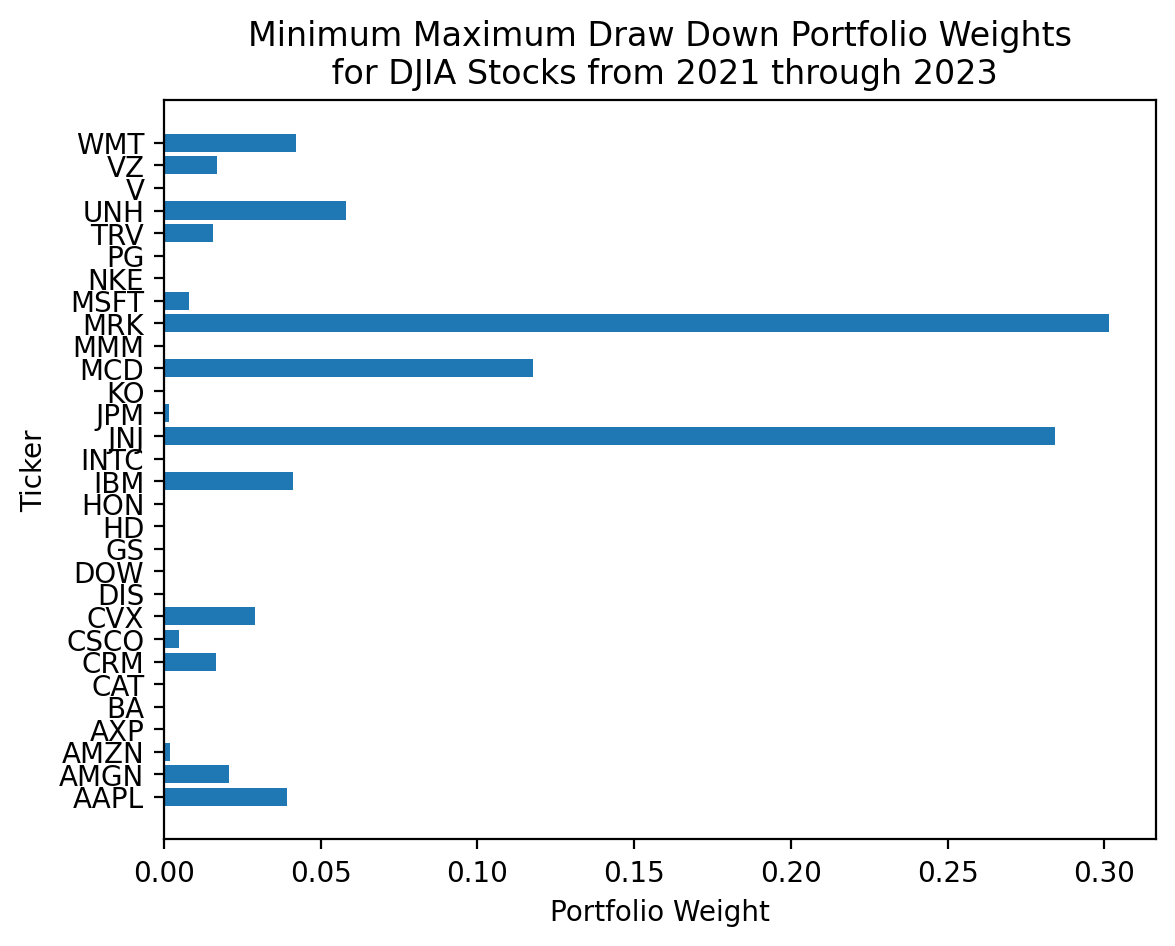

In [36]:
plt.barh(
    y=djia.columns,
    width=res_dd_2['x']
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Minimum Maximum Draw Down Portfolio Weights\n for DJIA Stocks from 2021 through 2023'
)
plt.show()

### Plot the (mean-variance) efficient frontier with all available data for the current the DJIA stocks

The range of target returns in `tret` span from the minimum to the maximum mean single-stock returns.
We will loop over these target returns, finding the minimum variance portfolio for each target return.

In [37]:
_ = djia.loc['2021':'2023'].mean().mul(252)
tret = np.linspace(_.min(), _.max(), 25)

In [38]:
def calc_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()

In [39]:
def calc_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [40]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=calc_vol, # minimize portfolio volatility
        x0=djia.pipe(get_equal_weights), # initial portfolio weights
        args=(djia.loc['2021':'2023'], 252), # additional arguments to fun, in order
        bounds=((0, 1) for c in djia.columns), # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {
                'type': 'eq', 
                'fun': lambda x: calc_mean(x=x, r=djia.loc['2021':'2023'], ppy=252) - t
            } # constrains portfolio mean return to the target return

        )
    )
    res_ef.append(_)

List `res_ef` contains the results of all 25 minimum-variance portfolios.
For example, `res_ef[0]` is the minimum variance portfolio for the lowest target return.

In [41]:
res_ef[0]

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2995484071443105
       x: [ 1.312e-16  0.000e+00 ...  5.056e-11  5.282e-17]
     nit: 3
     jac: [ 1.253e-01  3.352e-02 ...  4.880e-02  4.303e-02]
    nfev: 93
    njev: 3

I typically check that all portfolio volatility minimization succeeds.
If a portfolio volatility minimization fails, we should check our function, bounds, and constraints.

In [42]:
for r in res_ef:
    assert r['success'] 

We can combine the target returns and volatilities into a data frame `ef`.

In [43]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': [r['fun'] if r['success'] else np.nan for r in res_ef]
    }
)

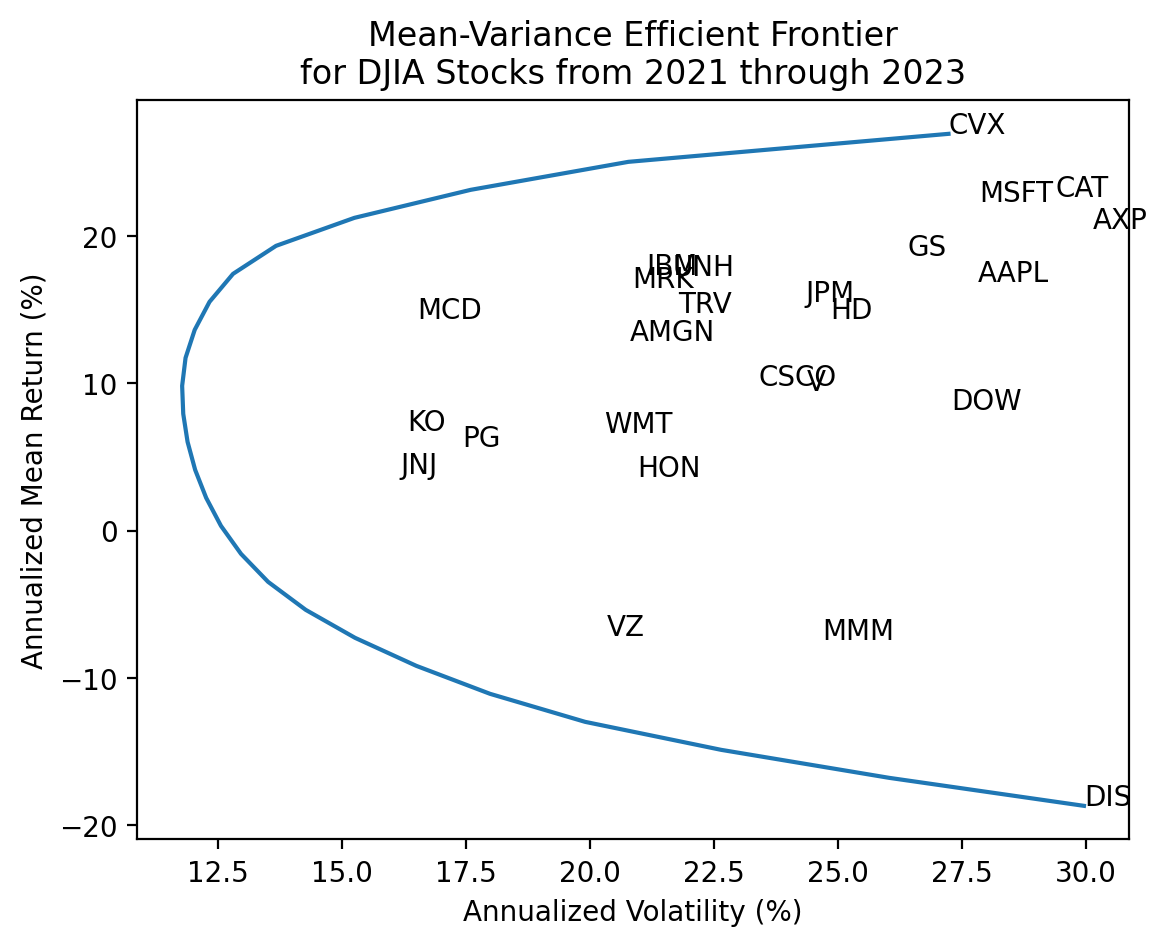

In [44]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title('Mean-Variance Efficient Frontier\nfor DJIA Stocks from 2021 through 2023')

for t, x, y in zip(
    djia.columns, 
    djia.loc['2021':'2023'].std().mul(100*np.sqrt(252)),
    djia.loc['2021':'2023'].mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

### Find the maximum Sharpe Ratio portfolio with all available data for the current the DJIA stocks

In [45]:
res_sr_5 = sco.minimize(
    fun=calc_neg_sharpe,
    x0=djia.pipe(get_equal_weights),
    args=(djia.loc['2021':'2023'], ff['RF'], 252),
    bounds=((0, 1) for c in djia.columns),
    constraints=(
        {'type':'eq', 'fun': lambda x: x.sum() - 1}
    )
)

res_sr_5

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.2674936065439388
       x: [ 3.138e-16  1.240e-02 ...  1.447e-15  0.000e+00]
     nit: 9
     jac: [ 1.679e-01 -1.458e-01 ...  1.165e+00  1.698e-01]
    nfev: 282
    njev: 9

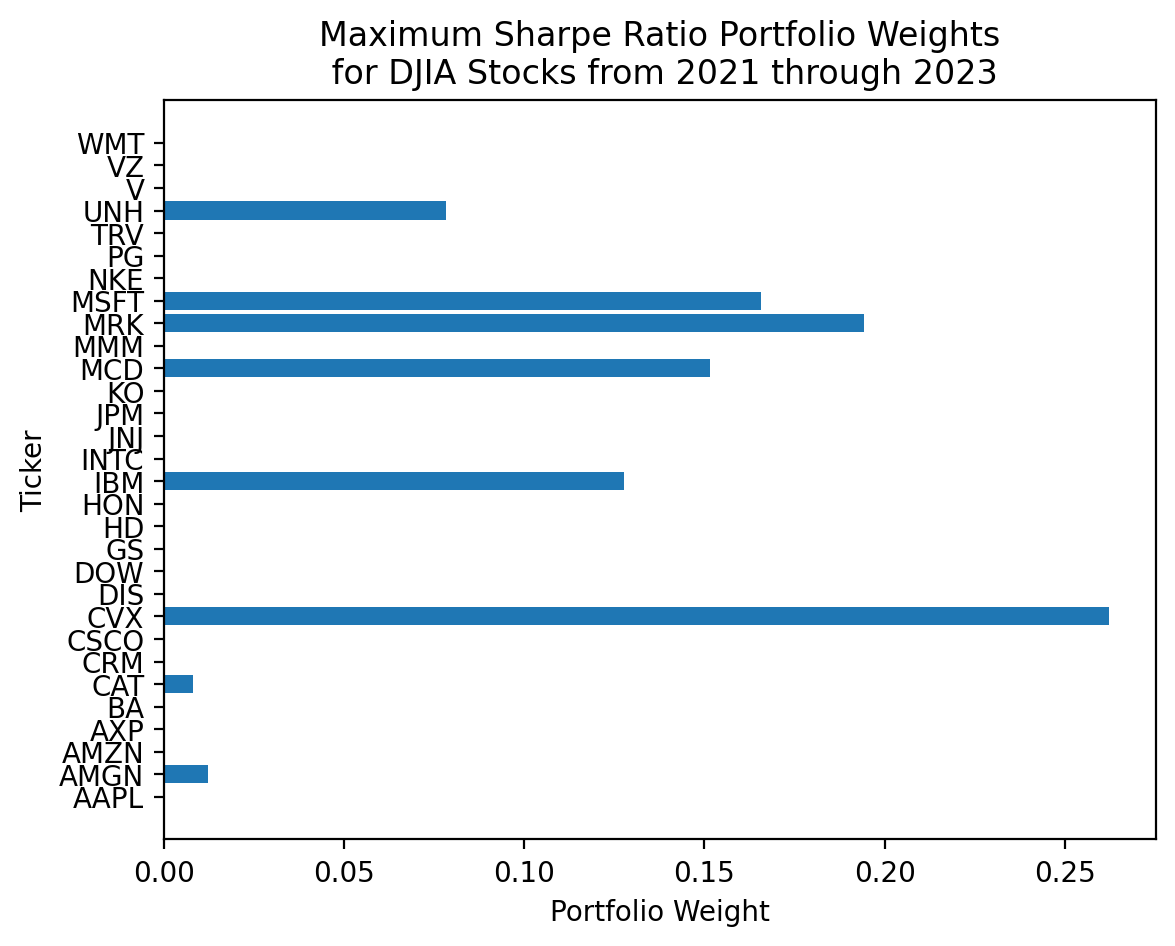

In [46]:
plt.barh(
    y=djia.columns,
    width=res_sr_5['x']
)
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Maximum Sharpe Ratio Portfolio Weights\n for DJIA Stocks from 2021 through 2023')
plt.show()

### Compare the $\frac{1}{n}$ and maximum Sharpe Ratio portfolios with all available data for the current DJIA stocks

Use all but the last 252 trading days to estimate the maximum Sharpe Ratio portfolio weights.
Then use the last 252 trading days of data to compare the $\frac{1}{n}$  maximum Sharpe Ratio portfolios.

In [47]:
res_sr_6 = sco.minimize(
    fun=calc_neg_sharpe,
    x0=djia.pipe(get_equal_weights),
    args=(djia.loc['2021':'2022'], ff['RF'], 252),
    bounds=((0, 1) for c in djia.columns),
    constraints=(
        {'type':'eq', 'fun': lambda x: x.sum() - 1}
    )
)

res_sr_6

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.8291519010866852
       x: [ 0.000e+00  0.000e+00 ...  2.240e-15  0.000e+00]
     nit: 7
     jac: [ 8.874e-01  5.597e-02 ...  1.586e+00  5.228e-01]
    nfev: 220
    njev: 7

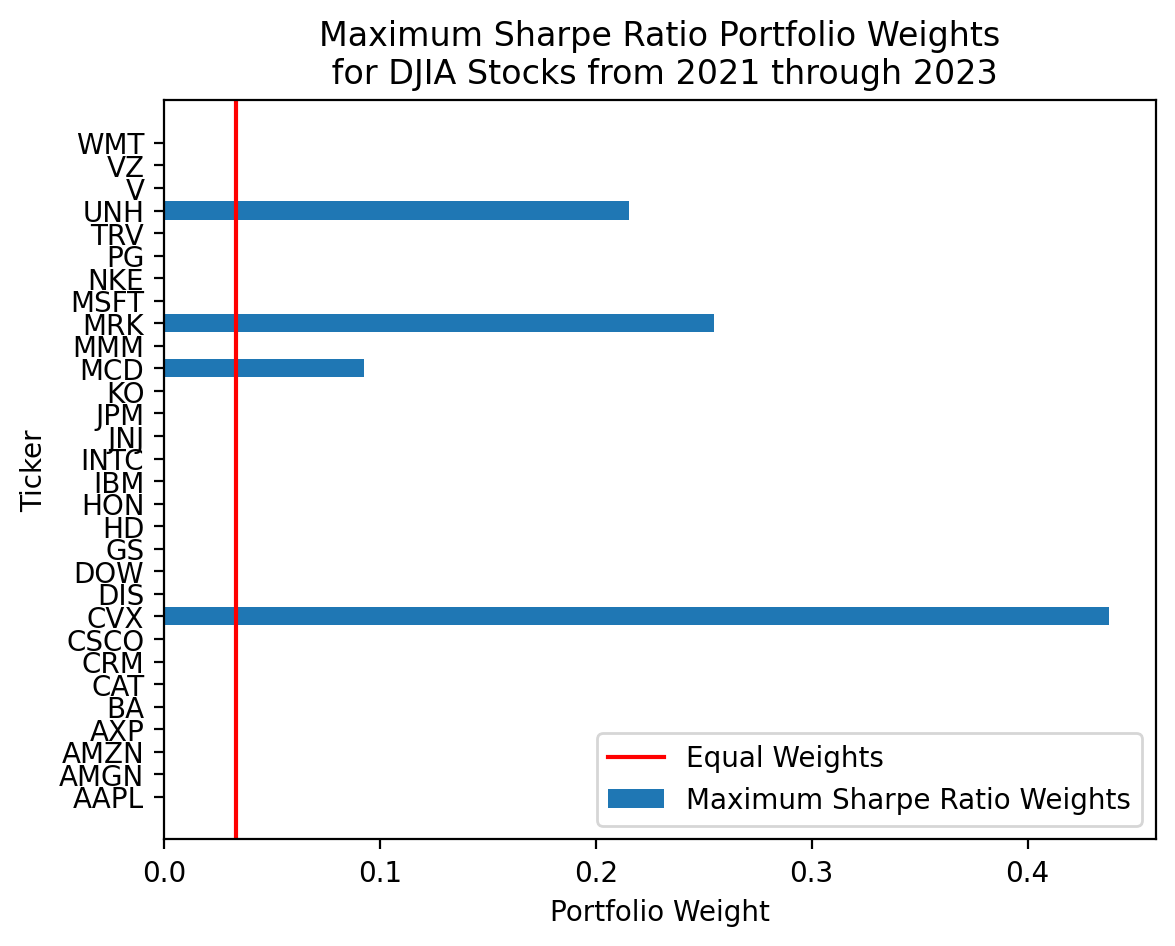

In [48]:
plt.barh(
    y=djia.columns,
    width=res_sr_6['x'],
    label='Maximum Sharpe Ratio Weights'
)
plt.axvline(1/30, color='red', label='Equal Weights')
plt.legend()
plt.ylabel('Ticker')
plt.xlabel('Portfolio Weight')
plt.title('Maximum Sharpe Ratio Portfolio Weights\n for DJIA Stocks from 2021 through 2023')
plt.show()

Here is the how max Sharpe portfolio does in 2023:

In [49]:
calc_sharpe(x=res_sr_6['x'], r=djia.loc['2023'], tgt=ff['RF'], ppy=252)

-0.5146

In [50]:
calc_sharpe(x=np.ones(djia.shape[1]) / djia.shape[1], r=djia.loc['2023'], tgt=ff['RF'], ppy=252)

1.2388

It is hard to beat the $\frac{1}{n}$ portfolio because mean returns are hard to predict!